# Preferential Bayesian Optimization: Dueling-Thompson Sampling

Implementation of the algorithm by Gonzalez et al (2017).

In [22]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sphviewer as sph
import sys
import os
import datetime
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.getcwd())[0])[0]) # Move 2 levels up directory to import PBO
import PBO

In [2]:
def log(message):
    print(str(datetime.datetime.now()) + ': ' + message)

In [3]:
def forrester(x):
    """
    1-dimensional test function by Forrester et al. (2008)
    Defined as f(x) = (6x-2)^2 * sin(12x-4)
    :param x: float in domain [0, 1]
    """
    return (6*x-2)*(6*x-2)*np.sin(12*x-4)


def forrester_get_y(x):
    """
    :param x: tensor of shape (..., N, 2)
    :return: tensor of shape (..., N, 1)
    """
    forrester_vals = forrester(x)
    return np.expand_dims(forrester_vals[..., 0] < forrester_vals[..., 1], axis=-1).astype(int)

Plot of the Forrester function (global min at ~0.757):

(-0.0, 1.0)

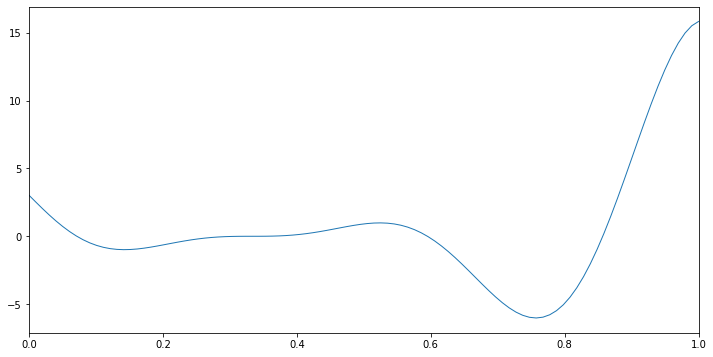

In [4]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, forrester(xx), 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [19]:
def visualize_model(query_points, m, title="Model", cmap="Spectral"):

    forrester_get_y(query_points)
    y_vals = np.squeeze(forrester_get_y(query_points), axis=-1)
    pos_vals = []
    neg_vals = []
    for i in range(len(y_vals)):
        if y_vals[i]:
            pos_vals.append(query_points[i])
        else:
            neg_vals.append(query_points[i])
    pos_vals = np.array(pos_vals)
    neg_vals = np.array(neg_vals)

    side = np.linspace(0,1,num_discrete_points)
    X,Y = np.meshgrid(side,side)
    combs = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
    preds = tf.transpose(tf.reshape(m.predict_y(combs)[0], [num_discrete_points, num_discrete_points]))
    variances = tf.transpose(tf.reshape(PBO.acquisitions.dts.variance_logistic_f(m, combs), [num_discrete_points, num_discrete_points]))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    fig.set_size_inches(18.5, 6.88)
    fig.set_dpi((200))
    
    ax1.axis('equal')
    if len(pos_vals) != 0:
        ax1.scatter(*pos_vals.T, c="black", marker="o")
    if len(neg_vals) != 0:
        ax1.scatter(*neg_vals.T, c="black", marker="x")
    im1 = ax1.imshow(preds, interpolation='nearest', extent=(0.0, 1.0, 0.0, 1.0), origin='lower', cmap=cmap)
    ax1.set_title("Mean of y(x, x')")
    ax1.set_xlabel("x")
    ax1.set_ylabel("x'")
    ax1.axvline(x=0.757, linestyle='--')
    fig.colorbar(im1, ax=ax1)

    ax2.axis('equal')
    if len(pos_vals) != 0:
        ax2.scatter(*pos_vals.T, c="black", marker="o")
    if len(neg_vals) != 0:
        ax2.scatter(*neg_vals.T, c="black", marker="x")
    im2 = ax2.imshow(variances, interpolation='nearest', extent=(0.0, 1.0, 0.0, 1.0), origin='lower', cmap=cmap)
    ax2.set_title("Variance of y(x, x')")
    ax2.set_xlabel("x")
    ax2.set_ylabel("x'")
    fig.colorbar(im2, ax=ax2)
    
    plt.savefig(fname="results/PBO_DTS " + title + ".png")

    plt.show()

In [6]:
def visualize_f_sample(f_vals, cmap="Spectral"):
    fig, (ax1) = plt.subplots(1)
    fig.suptitle('Sampled f values')
    fig.set_size_inches(4, 3.3)
    fig.set_dpi((100))
    
    ax1.axis('equal')
    im1 = ax1.imshow(tf.transpose(tf.reshape(f_vals, [num_discrete_points, num_discrete_points])),
                     interpolation='nearest', extent=(0.0, 1.0, 0.0, 1.0), origin='lower', cmap=cmap)
    ax1.set_xlabel("x")
    ax1.set_ylabel("x'")
    ax1.axvline(x=0.757, linestyle='--')
    fig.colorbar(im1, ax=ax1)

In [7]:
def train_and_visualize(X, title):
    m = gpflow.models.VGP(data=(X, forrester_get_y(X)),
                      kernel=gpflow.kernels.RBF(),
                      likelihood=gpflow.likelihoods.Bernoulli())
    m.kernel.lengthscale.assign(0.1)
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(lambda: -m.log_likelihood(), m.trainable_variables)
    visualize_model(X, m, title=title)
    return m

In [8]:
def best_guess(m, num_discrete_points=1000):
    """
    """
    side = np.linspace(0,1, num_discrete_points)
    X = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
    return PBO.acquisitions.dts.soft_copeland_maximizer(m.predict_f(X)[0])

Create the initial values for each run:

In [9]:
num_runs = 20
num_evals = 20
input_dims = 1
num_choices = 2
num_init_points = 5
num_discrete_points = 1000 # Discretization of continuous input space

In [10]:
np.random.seed(0)
init_points = np.random.uniform(size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

init_vals = np.squeeze(init_vals)  # in this formulation, inputs are 2-D
symmetric_vals = np.flip(init_vals, axis=-1)
init_vals = np.concatenate([init_vals, symmetric_vals], axis=-2)  # Model always has info about symmetric points

Store the results in these arrays:

In [11]:
num_data_at_end = (num_combs + num_evals) * 2
X_results = np.zeros([num_runs, num_data_at_end, num_choices])
y_results = np.zeros([num_runs, num_data_at_end, 1])
best_guess_results = np.zeros([num_runs, num_evals])

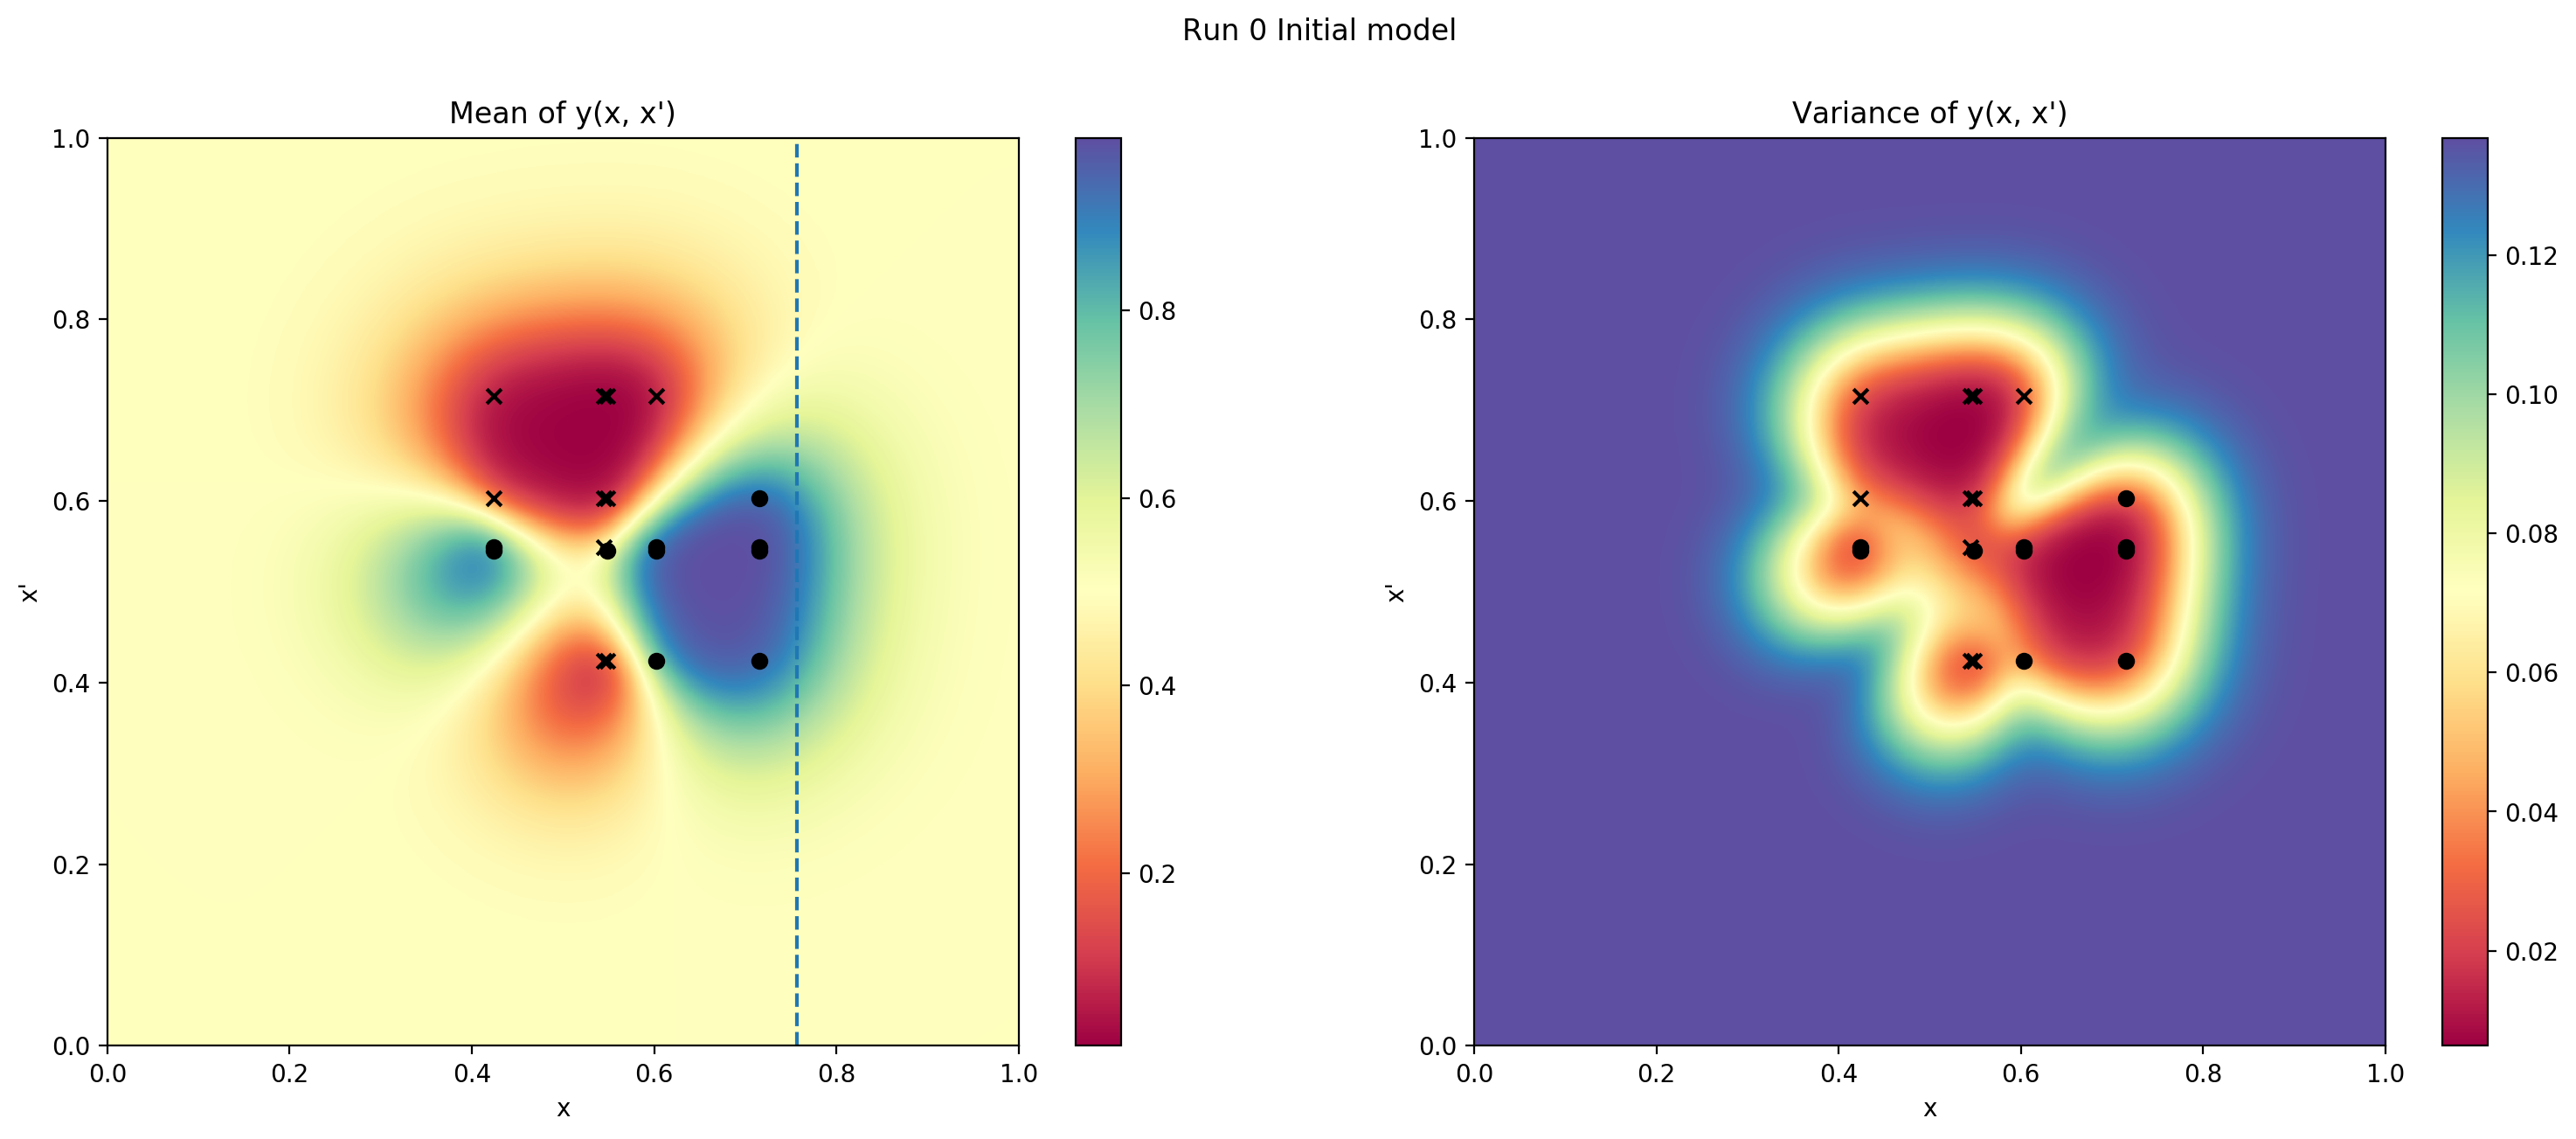

2020-01-22 18:55:22.773822: Starting evaluation 0
2020-01-22 18:55:25.312353: Computing acquisition function
2020-01-22 18:55:25.332711: x and x_prime: [0.11411411 0.06606607]
2020-01-22 18:55:25.332711: y_next: [1]


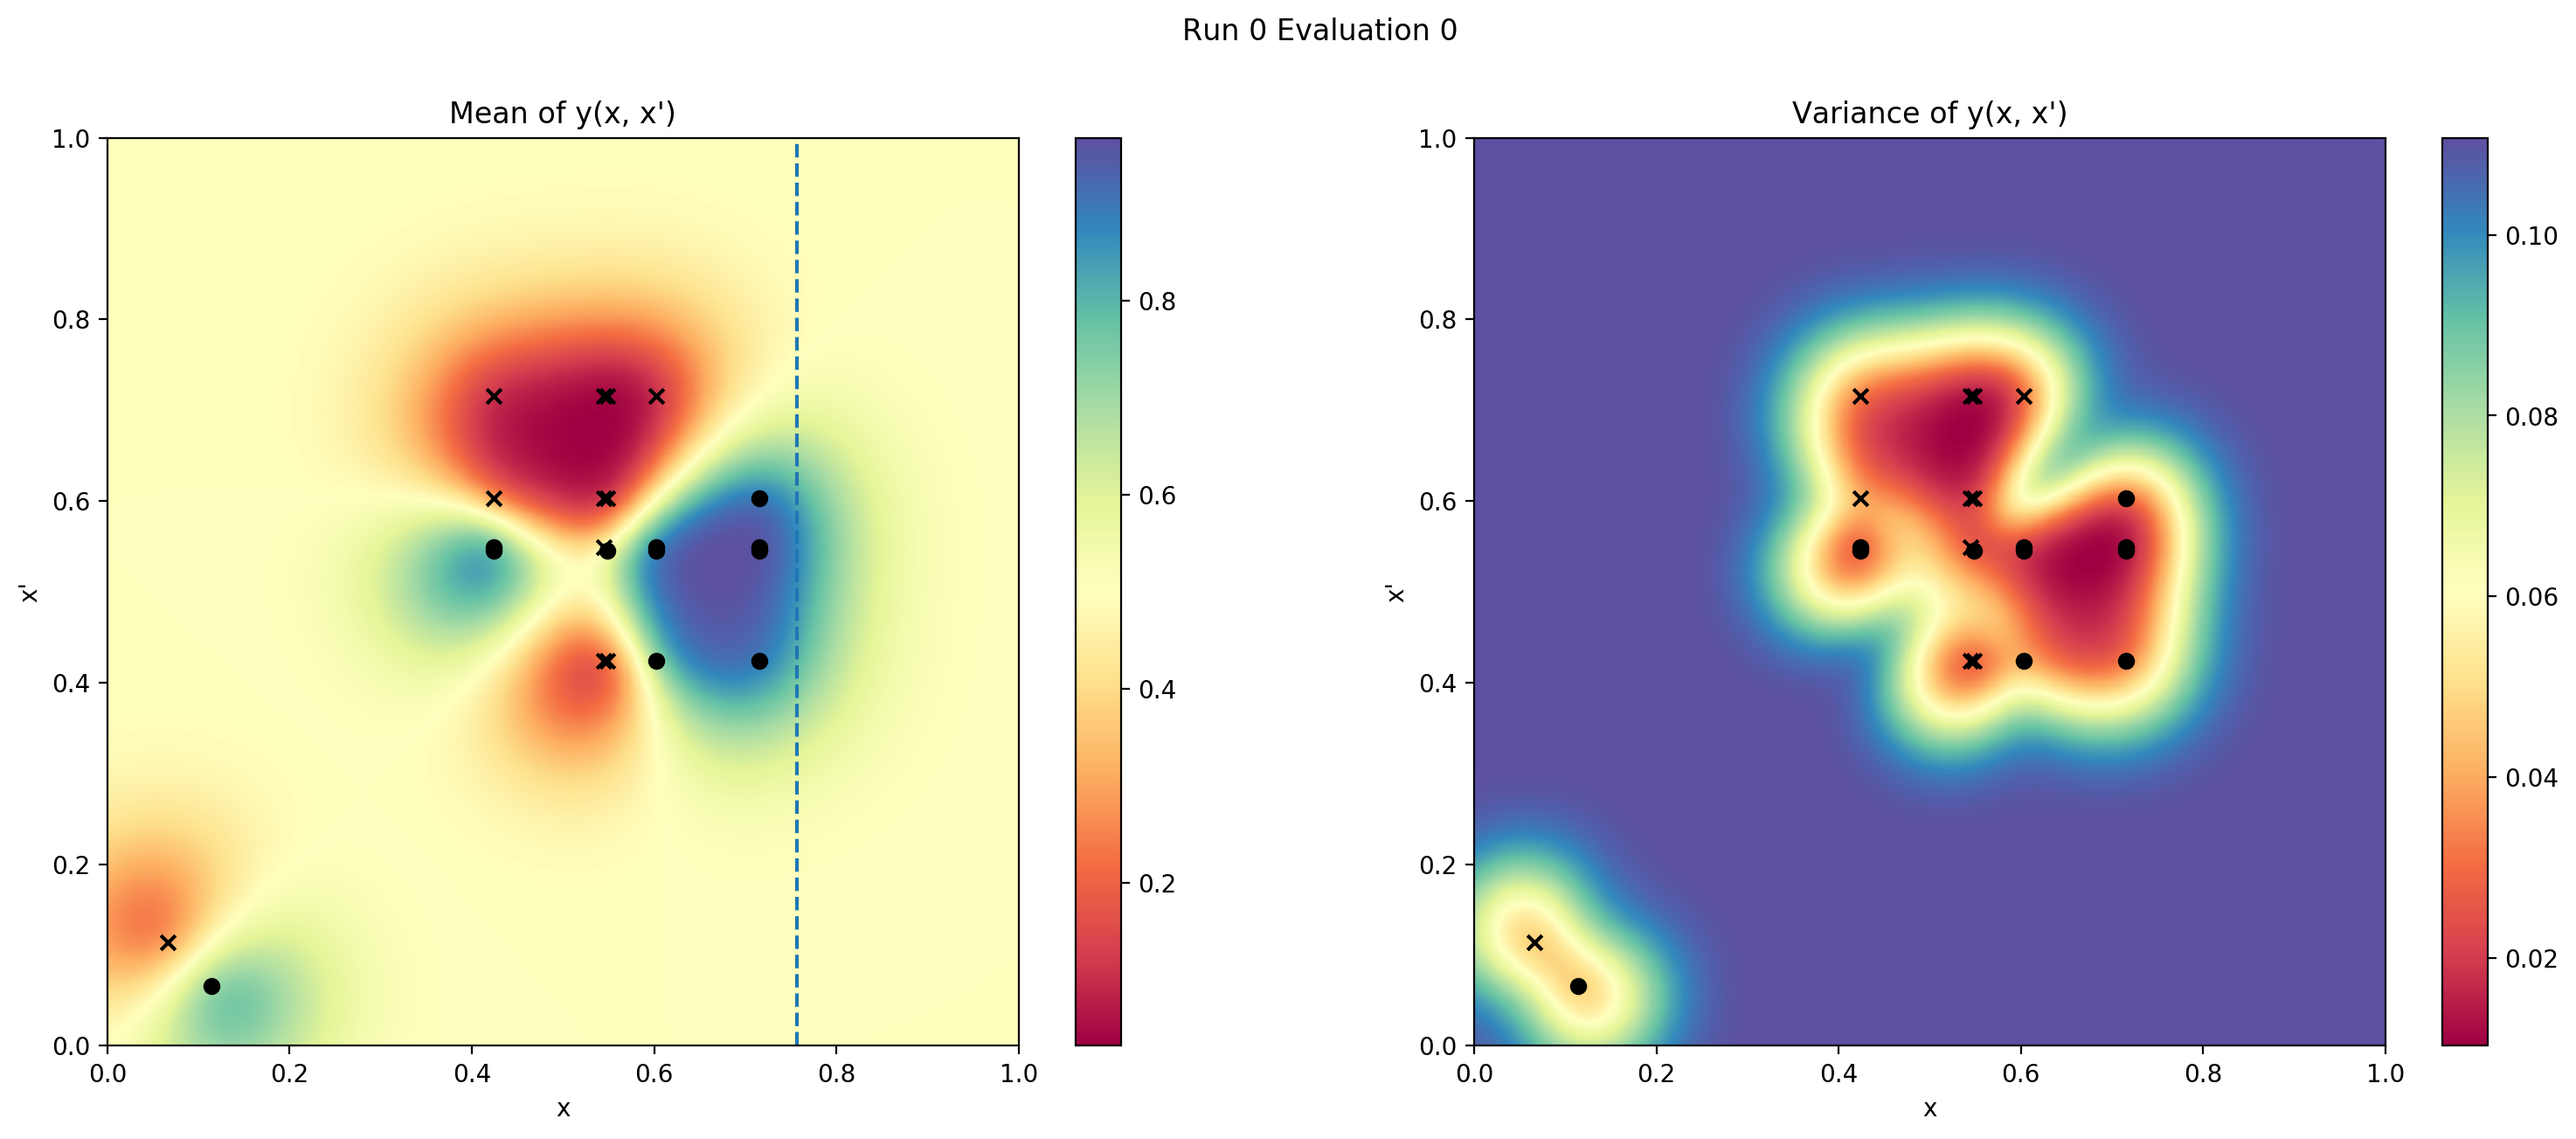

2020-01-22 18:55:34.519627: Starting evaluation 1
2020-01-22 18:55:37.128970: Computing acquisition function
2020-01-22 18:55:37.149916: x and x_prime: [1.       0.003003]
2020-01-22 18:55:37.149916: y_next: [0]


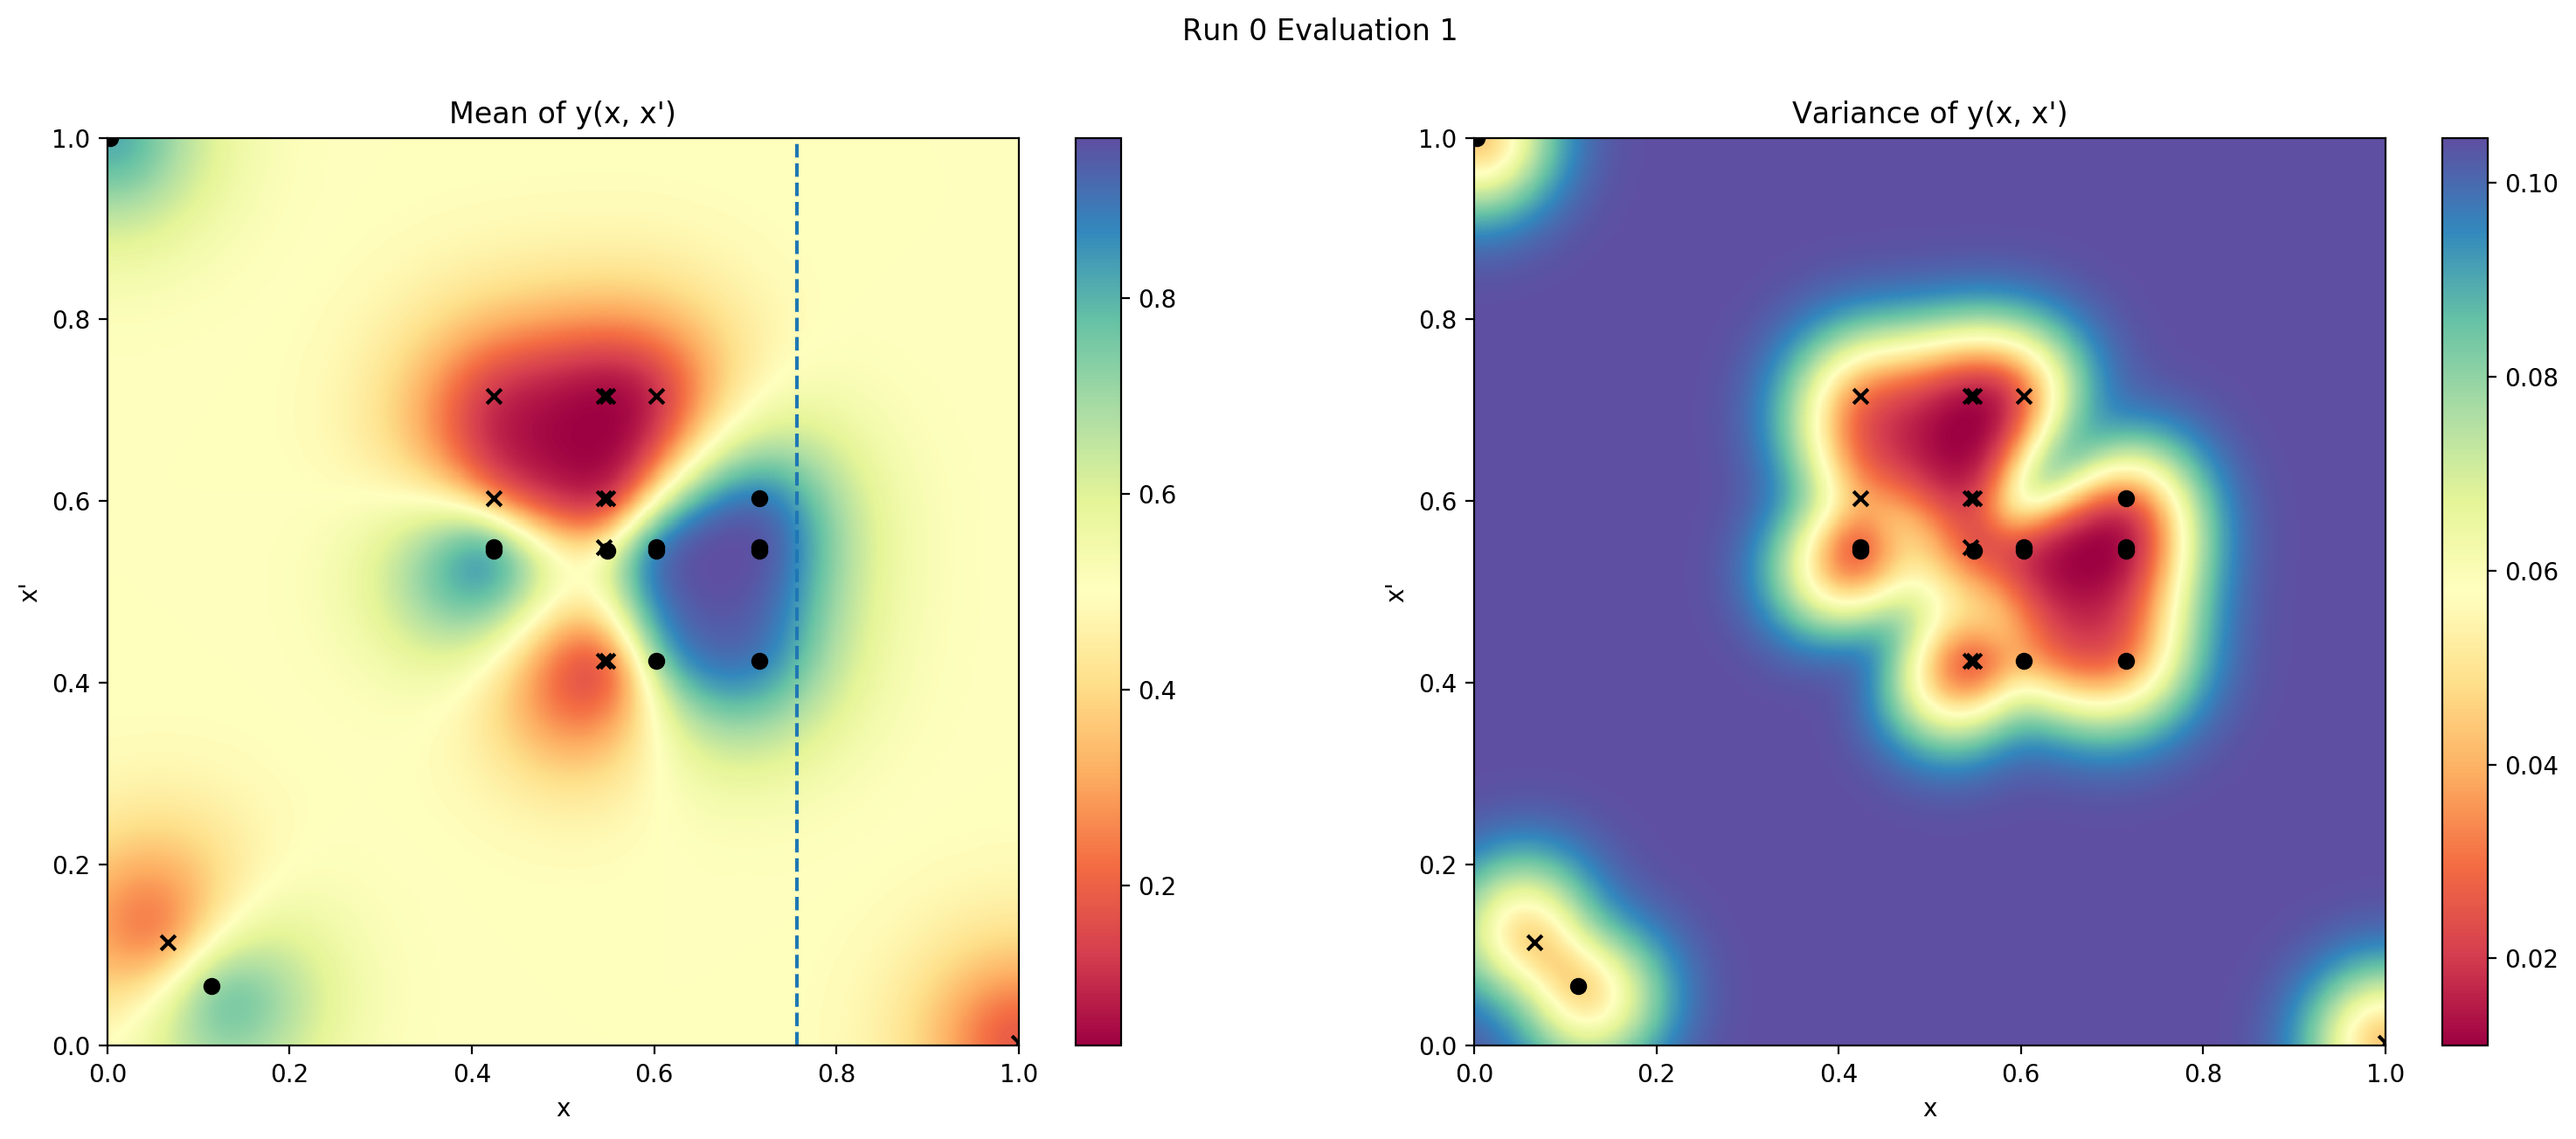

KeyboardInterrupt: 

In [20]:
for run in range(num_runs):
    #Fit a GP with kernel k to Dn
    
    X = init_vals[run]
    y = forrester_get_y(X)
    model = train_and_visualize(X, "Run {} Initial model".format(run))
    
    for evaluation in range(num_evals):
        log("Starting evaluation " + str(evaluation))
        
        # Sample f using RFF
        model.likelihood = gpflow.likelihoods.Gaussian()
        f_vals = PBO.acquisitions.dts.sample_f(model, X, num_discrete_points)

        # 2 and 3. Compute the acquisition for duels alpha and get next duel
        log("Computing acquisition function")
        x_next = PBO.acquisitions.dts.soft_copeland_maximizer(f_vals)
        
        points = np.linspace(0.0, 1.0, 1000)
        next_vars = np.squeeze(PBO.acquisitions.dts.variance_logistic_f(model, 
                                                                        np.concatenate([np.tile(x_next, 
                                                                                                (num_discrete_points, 1)), np.expand_dims(points, axis=1)], 
                                                                                       axis=1)), 
                               axis=1)
        xprime_next = points[np.argmax(next_vars)]
        
        x_xprime_next = np.array((x_next, xprime_next))
        log("x and x_prime: " + str(x_xprime_next))
        
        # 4. Run the duel and get y
        y_next = forrester_get_y(x_xprime_next)
        log("y_next: " + str(y_next))
        
        # 5. Augment X and Y, and add symmetric points
        X = np.vstack([X, x_xprime_next, np.flip(x_xprime_next)])
        y = np.vstack([y, y_next, forrester_get_y(np.flip(x_xprime_next))])
        
        # Fit a GP with kernel k to Dj and learn pi(x).
        model = train_and_visualize(X, "Run {} Evaluation {}".format(run, evaluation))
        
        # Get current best guess
        best_guess_results[run, evaluation] = best_guess(model, num_discrete_points)

    X_results[run] = X
    y_results[run] = y

In [27]:
pickle.dump((X_results, y_results, best_guess_results), open("results/PBO_DTS_results.p", "wb"))

In [ ]:
xx = np.linspace(0.0, 1.0, num_discrete_points).reshape(num_discrete_points, 1)
global_min = xx[np.argmin(forrester(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = abs(best_guess_results[i] - global_min)
    
    x_axis = list(range(11, 31))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess error', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()